In [1]:
# Import necessary libraries
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import lime.lime_tabular
import shap
import matplotlib.pyplot as plt
# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets
# Convert categorical target labels to numeric using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Display the split data
print("Training features:\n", X_train)
print("Testing features:\n", X_test)
print("Training labels:\n", y_train)
print("Testing labels:\n", y_test)

# Initialize the XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')


# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100))

c:\Users\weber\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\weber\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training features:
      radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
68     9.029     17.33       58.79   250.5      0.10660       0.14130   
181   21.090     26.57      142.70  1311.0      0.11410       0.28320   
63     9.173     13.86       59.20   260.9      0.07721       0.08751   
248   10.650     25.22       68.01   347.0      0.09657       0.07234   
60    10.170     14.88       64.55   311.9      0.11340       0.08061   
..       ...       ...         ...     ...          ...           ...   
71     8.888     14.64       58.79   244.0      0.09783       0.15310   
106   11.640     18.33       75.17   412.5      0.11420       0.10170   
270   14.290     16.82       90.30   632.6      0.06429       0.02675   
435   13.980     19.62       91.12   599.5      0.10600       0.11330   
102   12.180     20.52       77.22   458.7      0.08013       0.04038   

     concavity1  concave_points1  symmetry1  fractal_dimension1  ...  radius3  \
68      0.31300       

In [2]:
# Convert X_train and X_test to NumPy arrays for SHAP KernelExplainer
X_train_np = X_train.values
X_test_np = X_test.values

# Define the prediction function using the model's predict_proba method
def predict_proba(X):
    return model.predict_proba(X)

# Use KernelExplainer to explain model predictions
explainer = shap.KernelExplainer(predict_proba, X_train_np)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_np, nsamples=100)  # Adjust nsamples as needed

# Check the shape of SHAP values
print("SHAP values shape:", np.array(shap_values).shape)


Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 114/114 [00:58<00:00,  1.94it/s]

SHAP values shape: (114, 30, 2)


Top 10 Features and their SHAP values:
area1: 0.02425458720760464
compactness2: 0.024443818613603882
texture1: 0.025547214004702085
radius3: 0.027554914499145437
concavity3: 0.035121870785745864
texture3: 0.042849189113339486
area2: 0.046235841528821806
concave_points3: 0.0606451602951859
concave_points1: 0.06643454978166269
area3: 0.06783700613163511


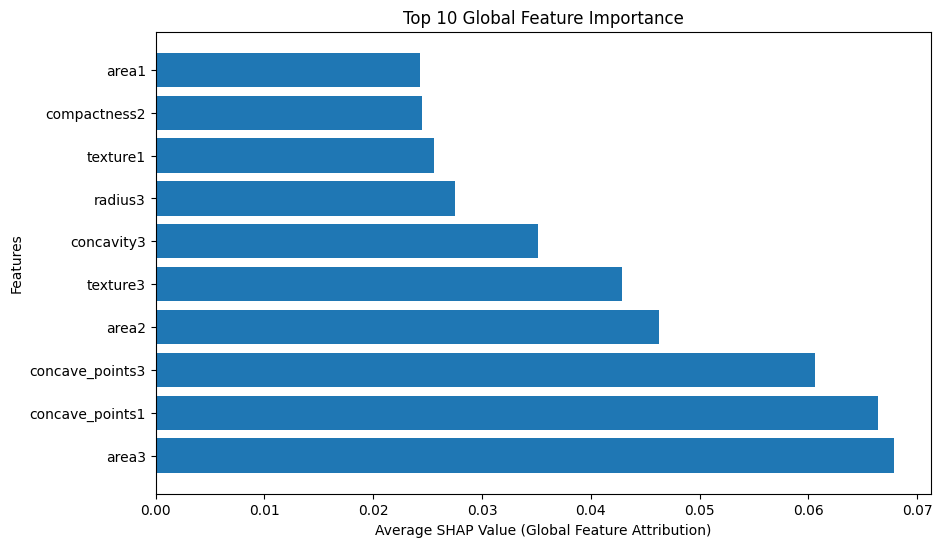

In [3]:
# Select SHAP values for class 1
shap_values_class1 = shap_values[:, :, 1]  # Select SHAP values for all samples, all features for class 1

# Calculate global importance for each feature (take the mean of the absolute SHAP values)
global_shap_importance = np.abs(shap_values_class1).mean(axis=0)

# Sort feature importance by magnitude and select the top 10 most important features
top_10_features = np.argsort(global_shap_importance)[-10:]

# Print the top 10 features and their SHAP values
print("Top 10 Features and their SHAP values:")
for feature, value in zip(X_test.columns[top_10_features], global_shap_importance[top_10_features]):
    print(f"{feature}: {value}")

# Plot a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_10_features)), global_shap_importance[top_10_features], align='center')
plt.yticks(range(len(top_10_features)), X_test.columns[top_10_features])  # Use feature names
plt.xlabel("Average SHAP Value (Global Feature Attribution)")
plt.ylabel("Features")
plt.title("Top 10 Global Feature Importance")
plt.gca().invert_yaxis()  # Ensure the most important feature is at the top
plt.show()


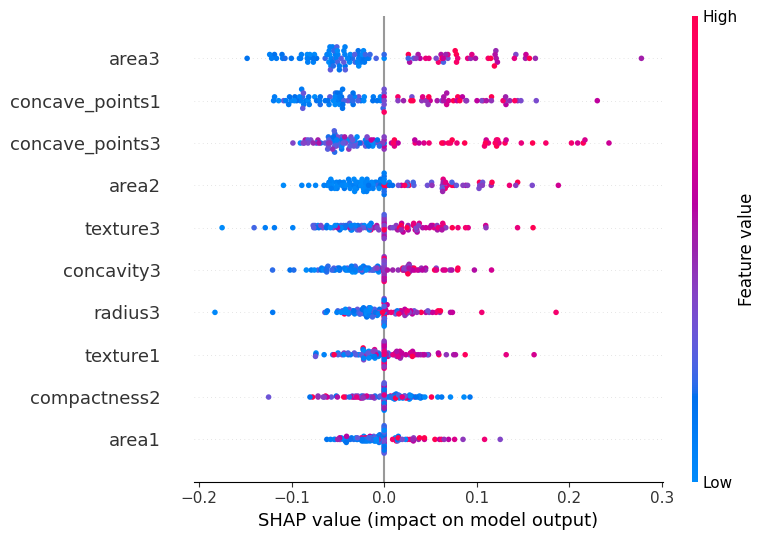

In [4]:
shap.summary_plot(shap_values_class1, X_test, plot_type="dot", max_display=10)

Confusion Matrix:
 [[69  2]
 [ 3 40]]
True Positive (most confident): 50
True Negative (most confident): 17
False Positive (most confident): 108
False Negative (most confident): 20
explainer.expected_value: -0.66878915
shap_values_true_positive: [[ 0.01629197  0.4518348   0.          0.39875123  0.32674268 -0.11350223
   0.22550453  1.498958    0.          0.10428908 -0.03188828 -0.00295013
  -0.01287743  0.8873843  -0.04233415  0.43856043  0.01928639 -0.1612722
   0.22155118 -0.00851108  0.42650673  0.52282953  0.2253972   1.5064279
   0.3301356   0.          0.6349167   1.2327243   0.50117046  0.        ]]


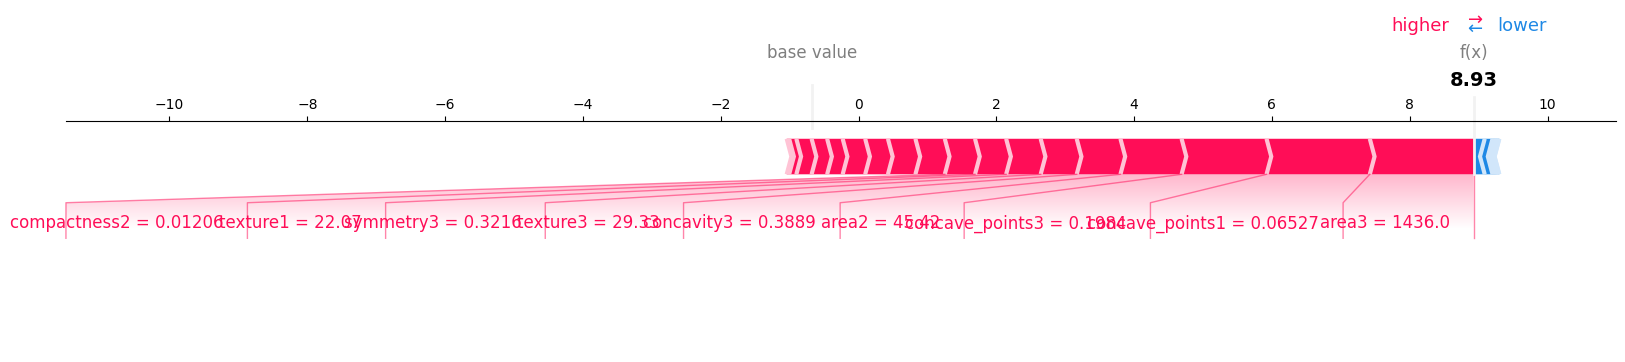

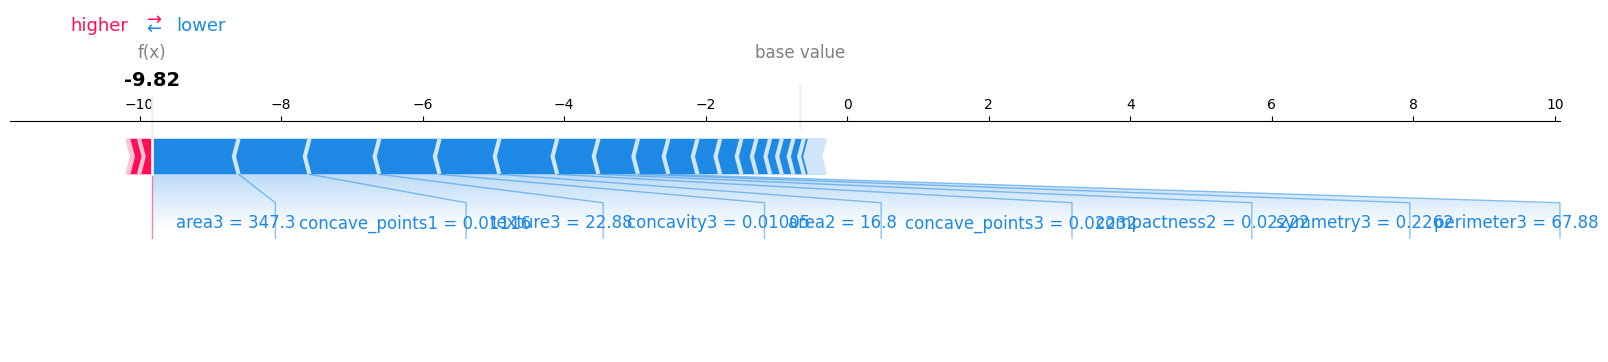

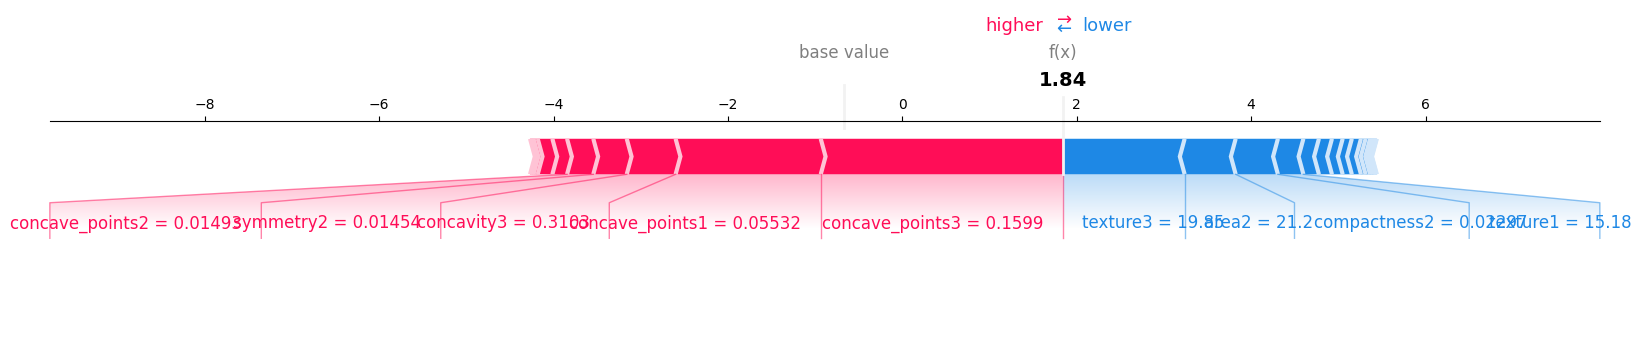

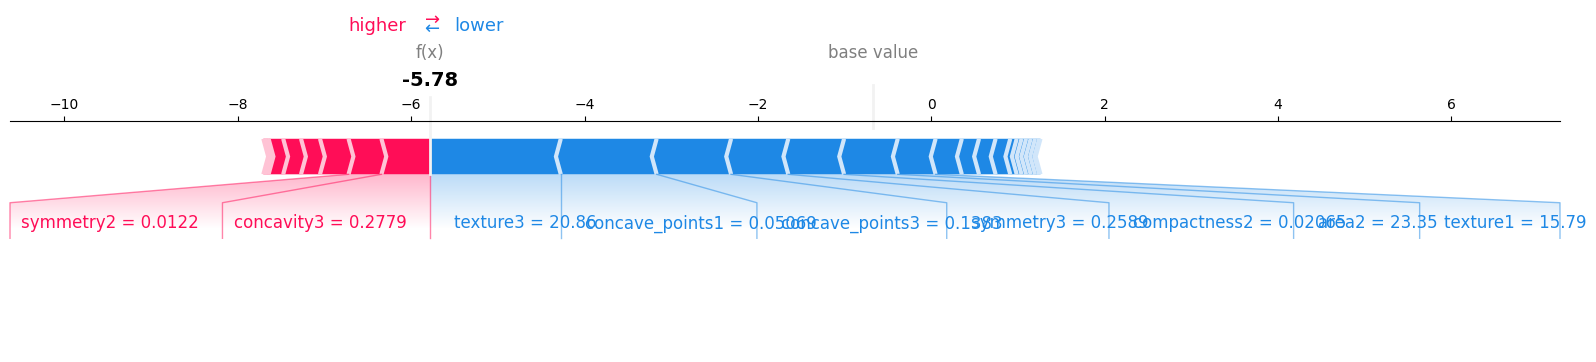

In [5]:
from sklearn.metrics import confusion_matrix
import numpy as np
import shap

# Get predicted probabilities (use the predict_proba function to get probabilities)
y_proba = model.predict_proba(X_test)

# Get predicted labels
y_pred = model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Output the confusion matrix
print("Confusion Matrix:\n", cm)

# Get the indices of true positives, true negatives, false positives, and false negatives
true_positive_indices = np.where((y_test == 1) & (y_pred == 1))[0]
true_negative_indices = np.where((y_test == 0) & (y_pred == 0))[0]
false_positive_indices = np.where((y_test == 0) & (y_pred == 1))[0]
false_negative_indices = np.where((y_test == 1) & (y_pred == 0))[0]

# Select the most confident and least confident samples
# For (a) True Positive, select the sample with the highest probability
most_confident_true_positive = true_positive_indices[np.argmax(y_proba[true_positive_indices][:, 1])]
# For (b) True Negative, select the sample with the lowest probability
most_confident_true_negative = true_negative_indices[np.argmin(y_proba[true_negative_indices][:, 1])]
# For (c) False Positive, select the sample with the highest probability
most_confident_false_positive = false_positive_indices[np.argmax(y_proba[false_positive_indices][:, 1])]
# For (d) False Negative, select the sample with the lowest probability
most_confident_false_negative = false_negative_indices[np.argmin(y_proba[false_negative_indices][:, 1])]

# Check the selected indices
print("True Positive (most confident):", most_confident_true_positive)
print("True Negative (most confident):", most_confident_true_negative)
print("False Positive (most confident):", most_confident_false_positive)
print("False Negative (most confident):", most_confident_false_negative)

# Use SHAP TreeExplainer to compute SHAP values
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the most and least confident samples
shap_values_true_positive = explainer.shap_values(X_test.iloc[[most_confident_true_positive]])
shap_values_true_negative = explainer.shap_values(X_test.iloc[[most_confident_true_negative]])
shap_values_false_positive = explainer.shap_values(X_test.iloc[[most_confident_false_positive]])
shap_values_false_negative = explainer.shap_values(X_test.iloc[[most_confident_false_negative]])

# Assuming this is a binary classification problem, select SHAP values for class 1
# For multi-class classification, shap_values will have an index for the corresponding class [1]
# Usually, class 1 is analyzed
print("explainer.expected_value:", explainer.expected_value)
print("shap_values_true_positive:", shap_values_true_positive)

# (a) True Positive force plot
shap.force_plot(explainer.expected_value, shap_values_true_positive, X_test.iloc[[most_confident_true_positive]], matplotlib=True)

# (b) True Negative force plot
shap.force_plot(explainer.expected_value, shap_values_true_negative, X_test.iloc[[most_confident_true_negative]], matplotlib=True)

# (c) False Positive force plot
shap.force_plot(explainer.expected_value, shap_values_false_positive, X_test.iloc[[most_confident_false_positive]], matplotlib=True)

# (d) False Negative force plot
shap.force_plot(explainer.expected_value, shap_values_false_negative, X_test.iloc[[most_confident_false_negative]], matplotlib=True)
